#### TODO
#### 1. Let us use Variant 5 (done)
#### 2. Decided to exclude x1 and x2 (done)
#### 3. Provide rationale for excluding x1 and x2 (To Be Done)
#### 4. Add runtime nb_black / modify anything required (done)
#### 5. Optimize vanilla GaussianNB and RandomForest Classifier (done)
#### 6. ML Performance with default parameters for PATECTGAN , DPGAN and QUAIL (In Progress)
#### 7. Configure QUAIL (configured but not yet trained)
#### 8. Hyperparamter Tuning for DPGAN (To be done)
#### 9. Loss function Plot (To be done)
#### 10. Distributional Similarity Plot (In progress /)
#### 11. ML Utility Code (done - refer DiffPriv_v3)
#### 12. pMSE code (done - refer DiffPriv_v3)
#### 13. Experimental Setup & Result compare Template (To be done)
#### 14. Compare methodology (Descriptive) (To be done)
#### 15. Before (Done) and After Coorelation plot (To be done)
#### 16. Cut a smaller dataset with less no. of features (done)
#### 17. Ensure each synth has a differnt name (done)
#### 18. Import this to collab and train (Ignore)
#### 19. Configure Tabletransformer and set preprocessor eps to zero (Done)

In [1]:
# Code starts here

In [2]:
# %load_ext autoreload
# %autoreload 2
# %load_ext nb_black

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# from sklearn.metrics import r2_curve
from sklearn.metrics import r2_score, roc_curve

# from rfpimp import permutation_importance

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [4]:
# Method to evaluate performance
def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    y_probs = clf.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, y_probs[:, 1])
    print("ROC AUC Score {}".format(roc_score))

    rf_fpr, rf_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.title("ROC Plot")
    plt.plot(rf_fpr, rf_tpr, "b", marker=".", label="Test, AUC= %0.2f" % roc_score)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive rate")
    plt.xlabel("False Positive Rate")
    plt.show()

In [5]:
# Feature importance by reducing Impurity
def plotFeatureImportance(title, clf, plt, features):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=features)
    print(forest_importances)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature Importance Using {} data".format(title))
    ax.set_ylabel("Mean decrease in Impurity")
    fig.tight_layout()

In [6]:
# Plot Feature Importance by Importance
def plotFeatureImportanceByValue(title, clf, plt, features):
    featureList = []
    for feat, importance in zip(features, clf.feature_importances_):
        running_feature = [feat, importance]
        featureList.append(running_feature)
    dfFeature = pd.DataFrame(featureList, columns=["feature", "importance"])
    dfFeature = dfFeature.sort_values(by=["importance"], ascending=False)
    dfFeature.plot(x="feature", y="importance", kind="bar")
    plt.title("Feature importance of {} data by importance".format(title))
    plt.xlabel("Feature")
    plt.xlabel("Importance")
    plt.show()

In [7]:
seed = 42

In [8]:
dfPrivate = pd.read_csv("data/Variant_5.csv")
print(dfPrivate.shape)
dfPrivate.head()

(1000000, 34)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,x1,x2
0,0,0.1,0.054656,-1,55,50,0.029642,-0.779957,AB,1735,...,0,INTERNET,5.063178,linux,0,1,0,2,-0.833286,-0.239018
1,0,0.2,0.516874,-1,178,50,0.036917,-0.471011,AB,910,...,0,INTERNET,5.403648,linux,0,1,0,3,-0.044042,1.174898
2,0,0.1,0.870572,-1,26,30,11.838249,51.068616,AA,1730,...,0,INTERNET,6.701977,linux,1,1,0,2,2.094070,0.643121
3,0,0.1,0.234248,29,9,20,0.030793,16.341333,AA,533,...,0,INTERNET,12.787474,linux,1,1,0,7,-1.060523,0.285319
4,0,0.2,0.909504,11,5,30,0.036117,-1.151589,AB,2935,...,0,INTERNET,4.670977,linux,0,1,0,2,1.989430,-0.803668


In [9]:
dfPrivate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [10]:
print(dfPrivate.payment_type.value_counts())
print(dfPrivate.employment_status.value_counts())
print(dfPrivate.housing_status.value_counts())
print(dfPrivate.source.value_counts())
print(dfPrivate.device_os.value_counts())

AB    399073
AA    249581
AC    246596
AD    104489
AE       261
Name: payment_type, dtype: int64
CA    685037
CB    134222
CC     89437
CF     45225
CD     26963
CE     18653
CG       463
Name: employment_status, dtype: int64
BC    336096
BB    301948
BA    214920
BE    118602
BD     26533
BF      1664
BG       237
Name: housing_status, dtype: int64
INTERNET    992330
TELEAPP       7670
Name: source, dtype: int64
linux        337150
windows      304492
other        299948
macintosh     50226
x11            8184
Name: device_os, dtype: int64


In [11]:
cat_cols = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]
le = LabelEncoder()
dfPrivate["payment_type"] = le.fit_transform(dfPrivate["payment_type"])
dfPrivate["employment_status"] = le.fit_transform(dfPrivate["employment_status"])
dfPrivate["housing_status"] = le.fit_transform(dfPrivate["housing_status"])
dfPrivate["source"] = le.fit_transform(dfPrivate["source"])
dfPrivate["device_os"] = le.fit_transform(dfPrivate["device_os"])
# dfPrivate["fraud_bool"] = dfPrivate["fraud_bool"].astype("category")
# for col in cat_cols:
# dfPrivate[str(col)] = le.fit_transform(str(dfPrivate[col]))

In [12]:
print(dfPrivate.isnull().values.any())
print("---------------------------------------------------")
print(dfPrivate.isna().any())

False
---------------------------------------------------
fraud_bool                          False
income                              False
name_email_similarity               False
prev_address_months_count           False
current_address_months_count        False
customer_age                        False
days_since_request                  False
intended_balcon_amount              False
payment_type                        False
zip_count_4w                        False
velocity_6h                         False
velocity_24h                        False
velocity_4w                         False
bank_branch_count_8w                False
date_of_birth_distinct_emails_4w    False
employment_status                   False
credit_risk_score                   False
email_is_free                       False
housing_status                      False
phone_home_valid                    False
phone_mobile_valid                  False
bank_months_count                   False
has_other_cards   

In [13]:
all_cols = dfPrivate.columns.tolist()
print(len(all_cols))
cols_excluded = ["x1", "x2"]
features_selected = [x for x in all_cols if x not in cols_excluded]
print(len(features_selected))
print(features_selected)

34
32
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


In [14]:
# Create Correlation Plot for feature selection

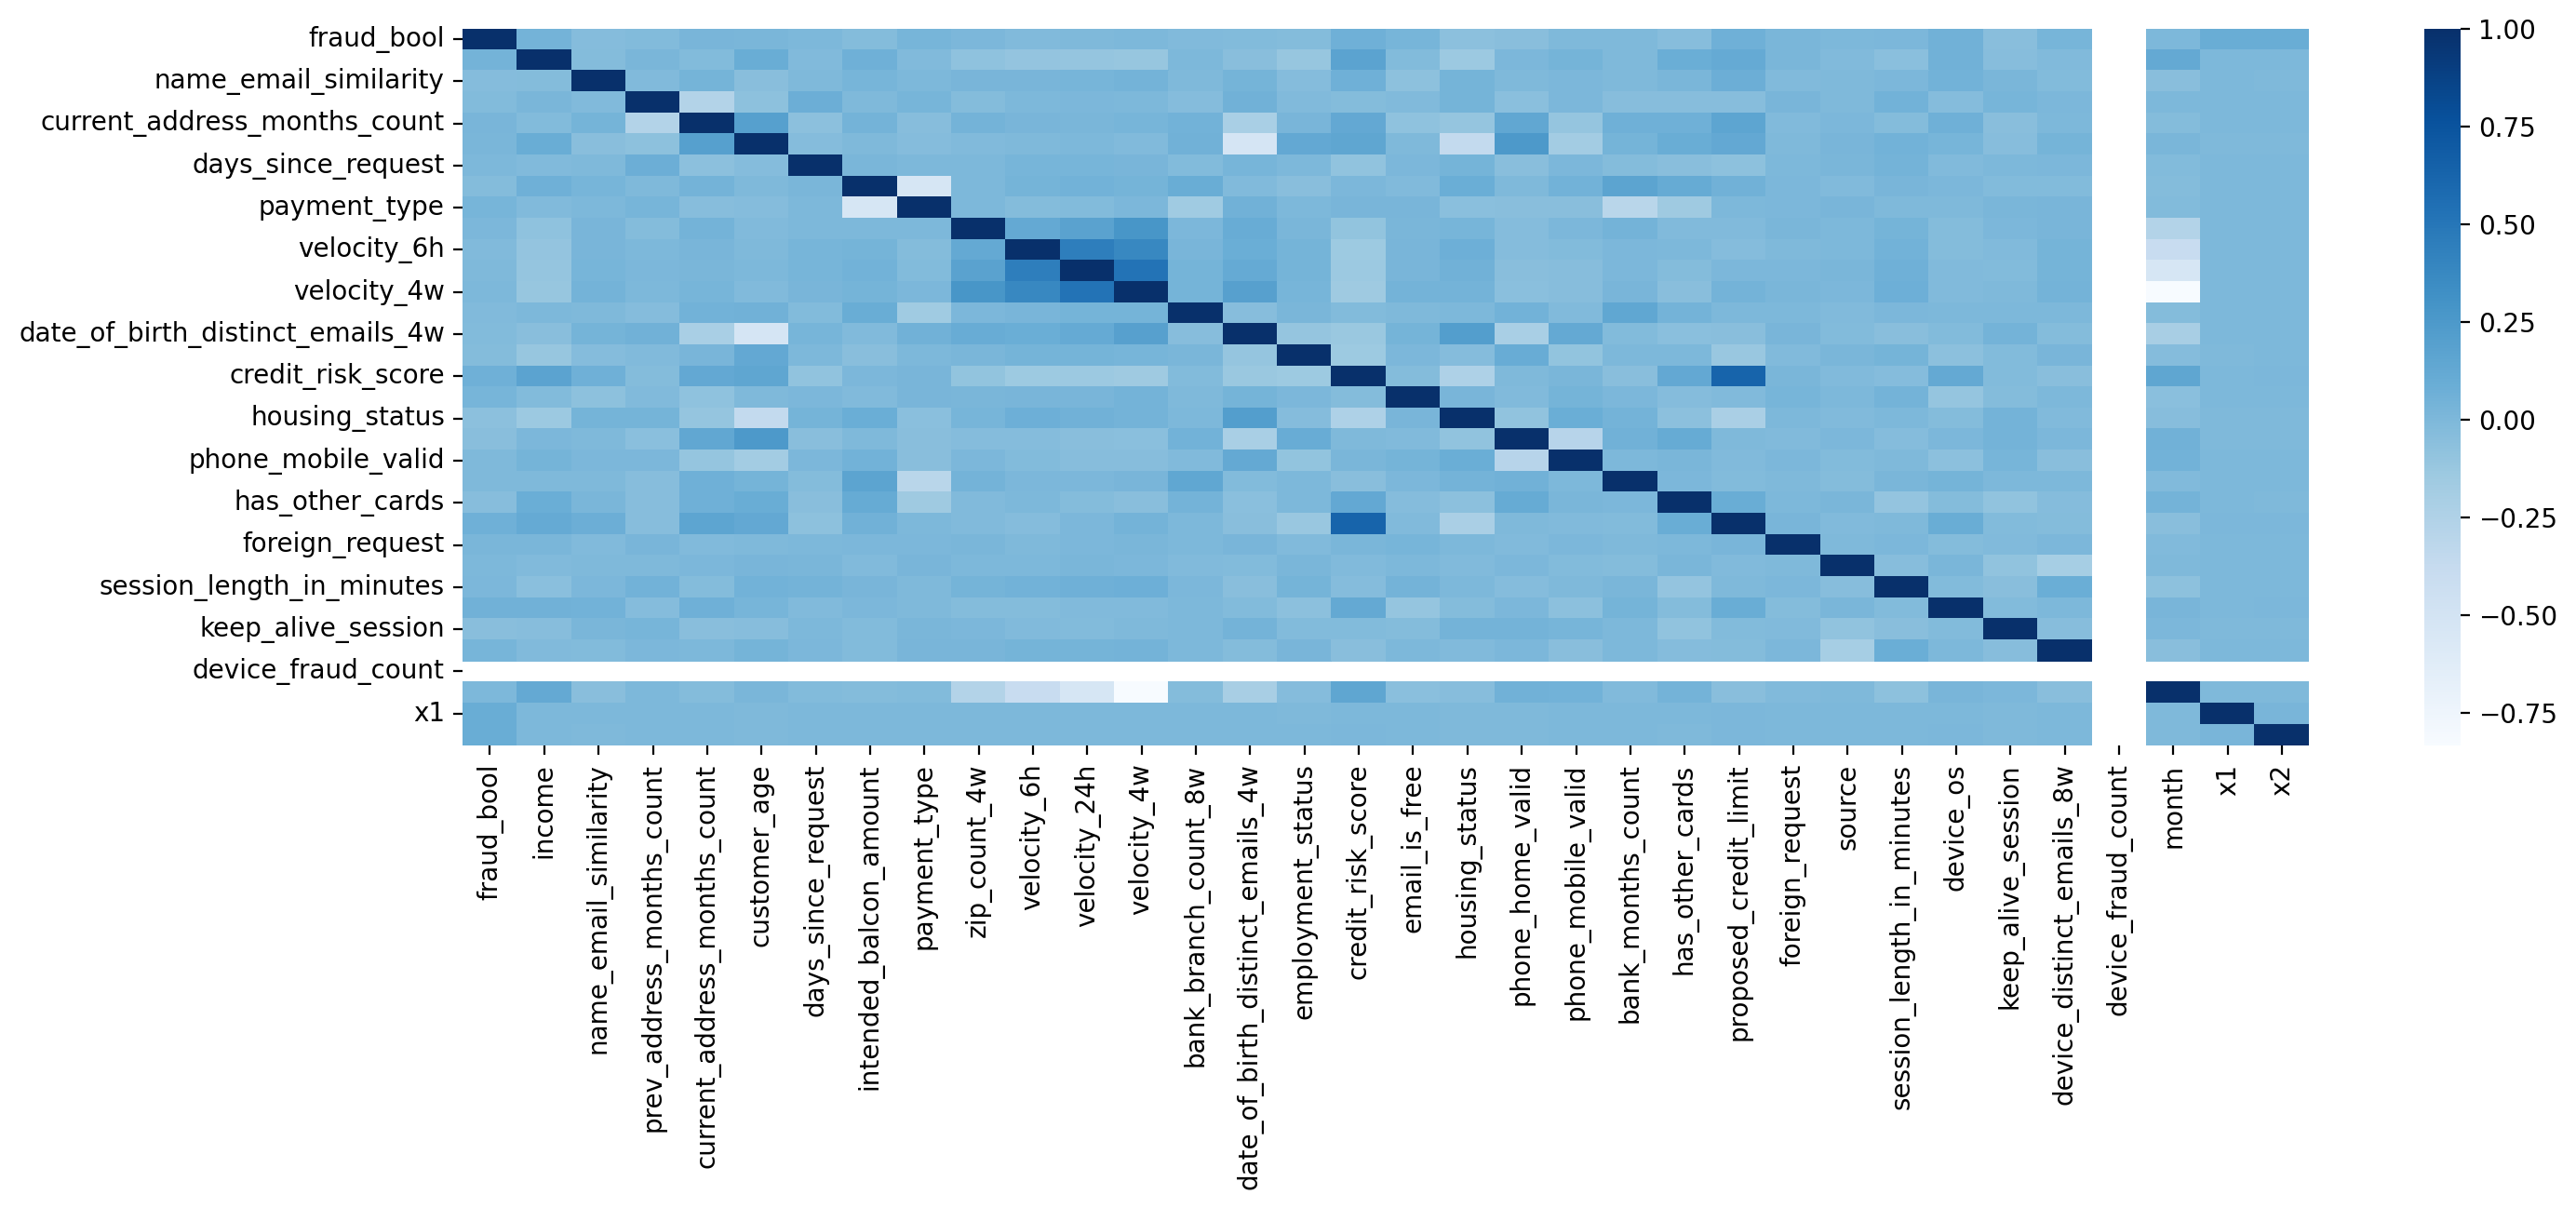

In [15]:
plt.figure(figsize=(16, 5))
corr = dfPrivate.corr()
ax = sns.heatmap(corr, cmap="Blues", annot=False)

In [16]:
dfPrivate = dfPrivate[features_selected]
print(dfPrivate.shape)
dfPrivate.head()

(1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.1,0.054656,-1,55,50,0.029642,-0.779957,1,1735,...,0,200.0,0,0,5.063178,0,0,1,0,2
1,0,0.2,0.516874,-1,178,50,0.036917,-0.471011,1,910,...,0,200.0,0,0,5.403648,0,0,1,0,3
2,0,0.1,0.870572,-1,26,30,11.838249,51.068616,0,1730,...,1,200.0,0,0,6.701977,0,1,1,0,2
3,0,0.1,0.234248,29,9,20,0.030793,16.341333,0,533,...,0,200.0,0,0,12.787474,0,1,1,0,7
4,0,0.2,0.909504,11,5,30,0.036117,-1.151589,1,2935,...,1,200.0,0,0,4.670977,0,0,1,0,2


In [17]:
# dfPrivate.corr().iloc[:-1,-1]
print(np.corrcoef(dfPrivate[dfPrivate.columns[:]].T)[-1][:-1])

[ 0.0027703   0.1246379  -0.04551496 -0.00154753 -0.02812459  0.01525461
 -0.02146303 -0.02824374 -0.0198709  -0.26639213 -0.39261882 -0.53034329
 -0.83308907 -0.02967822 -0.19592044 -0.03238269  0.15471359 -0.05267655
 -0.04457806  0.06010688  0.04899316 -0.01252018  0.04141463 -0.05084225
 -0.01049715 -0.0064131  -0.07298938  0.01979079  0.00519772 -0.05095431
         nan]


In [18]:
print(dfPrivate[dfPrivate.columns[:]].corr()["fraud_bool"])

fraud_bool                          1.000000
income                              0.041016
name_email_similarity              -0.031502
prev_address_months_count          -0.022450
current_address_months_count        0.023834
customer_age                        0.018788
days_since_request                  0.003553
intended_balcon_amount             -0.023989
payment_type                        0.031470
zip_count_4w                        0.008753
velocity_6h                        -0.012831
velocity_24h                       -0.005003
velocity_4w                        -0.002470
bank_branch_count_8w               -0.014682
date_of_birth_distinct_emails_4w   -0.019157
employment_status                  -0.027289
credit_risk_score                   0.068499
email_is_free                       0.029273
housing_status                     -0.066345
phone_home_valid                   -0.047340
phone_mobile_valid                 -0.005265
bank_months_count                  -0.005320
has_other_

In [19]:
dfPrivate.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [20]:
final_feature_selected = [
    "fraud_bool",
    "income",
    "name_email_similarity",
    "payment_type",
    "employment_status",
    "credit_risk_score",
    "housing_status",
    "phone_home_valid",
    "has_other_cards",
    "proposed_credit_limit",
    "device_os",
    "keep_alive_session",
]

In [21]:
dfPrivate = dfPrivate[final_feature_selected]
print(dfPrivate.shape)
dfPrivate.head()

(1000000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.1,0.054656,1,2,74,1,1,0,200.0,0,0
1,0,0.2,0.516874,1,2,164,1,1,0,200.0,0,0
2,0,0.1,0.870572,0,0,169,2,0,1,200.0,0,1
3,0,0.1,0.234248,0,0,75,2,1,0,200.0,0,1
4,0,0.2,0.909504,1,1,129,1,0,1,200.0,0,0


In [22]:
print(dfPrivate[dfPrivate.columns[:]].corr()["fraud_bool"])

fraud_bool               1.000000
income                   0.041016
name_email_similarity   -0.031502
payment_type             0.031470
employment_status       -0.027289
credit_risk_score        0.068499
housing_status          -0.066345
phone_home_valid        -0.047340
has_other_cards         -0.038587
proposed_credit_limit    0.067985
device_os                0.056967
keep_alive_session      -0.050665
Name: fraud_bool, dtype: float64


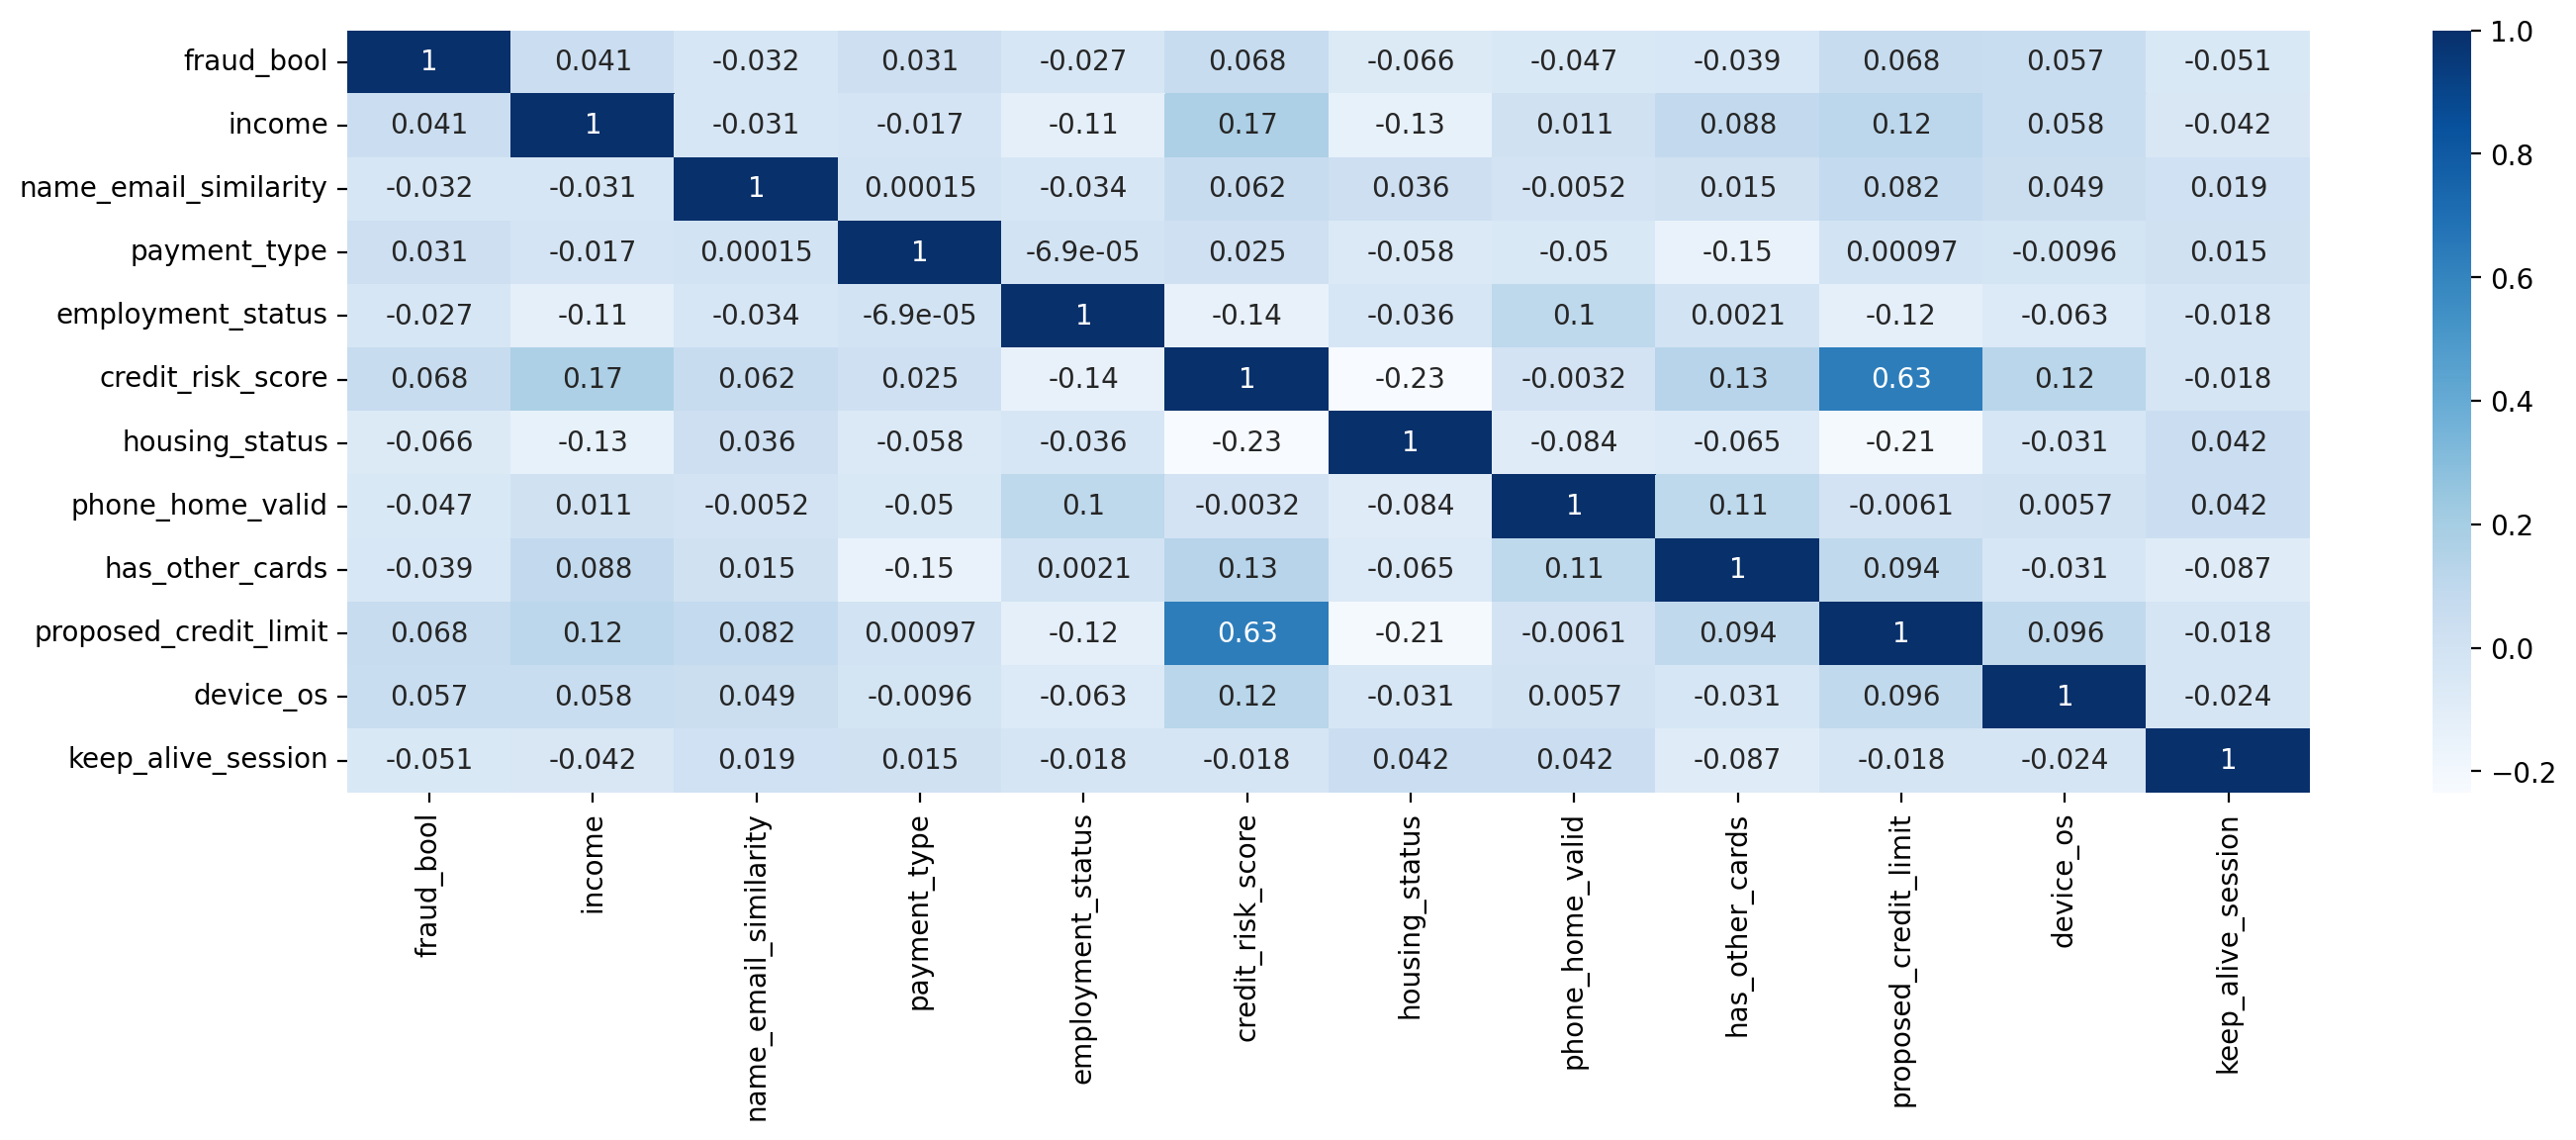

In [23]:
plt.figure(figsize=(16, 5))
corr = dfPrivate.corr()
ax = sns.heatmap(corr, cmap="Blues", annot=True)

In [24]:
Xy_train, Xy_test = train_test_split(
    dfPrivate, test_size=0.3, stratify=dfPrivate["fraud_bool"], random_state=seed
)
print(Xy_train.shape, Xy_test.shape)
display(Xy_train.head())
display(Xy_test.head())

(700000, 12) (300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
336722,0,0.9,0.323914,2,0,85,0,1,0,200.0,3,1
602823,0,0.8,0.520927,1,5,180,2,0,0,200.0,3,0
236576,0,0.9,0.086442,1,0,269,1,1,1,1500.0,3,1
271511,0,0.9,0.779473,0,0,152,2,0,0,200.0,3,0
77499,0,0.6,0.344351,0,0,187,2,1,1,1500.0,0,0


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
872009,0,0.4,0.208878,2,5,160,2,1,0,200.0,0,1
638219,0,0.8,0.993504,1,1,197,0,0,0,1500.0,3,1
661244,0,0.8,0.265069,1,0,163,2,0,1,500.0,0,1
146925,0,0.1,0.263270,1,0,193,2,1,0,200.0,3,1
748341,0,0.3,0.438486,1,2,41,1,0,1,200.0,2,0


In [25]:
# Make Test Set as Target set
Xy_test["fraud_bool"].value_counts()


0    296691
1      3309
Name: fraud_bool, dtype: int64

In [26]:
print((3309 / 300000) * 100)
print((11030 / 1000000) * 100)

1.103
1.103


In [27]:
dfPrivate = Xy_test.copy()
dfPrivate.reset_index(drop=True, inplace=True)
print(dfPrivate.shape)
dfPrivate.head()

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.4,0.208878,2,5,160,2,1,0,200.0,0,1
1,0,0.8,0.993504,1,1,197,0,0,0,1500.0,3,1
2,0,0.8,0.265069,1,0,163,2,0,1,500.0,0,1
3,0,0.1,0.263270,1,0,193,2,1,0,200.0,3,1
4,0,0.3,0.438486,1,2,41,1,0,1,200.0,2,0


In [28]:
Xy_train, Xy_test = train_test_split(
    dfPrivate, test_size=0.3, stratify=dfPrivate["fraud_bool"], random_state=seed
)
print(Xy_train.shape, Xy_test.shape)
display(Xy_train.head())
display(Xy_test.head())

(210000, 12) (90000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
30628,0,0.5,0.892307,0,1,84,2,0,1,1500.0,3,0
205000,0,0.8,0.750793,0,0,165,1,1,1,1500.0,0,1
150790,0,0.6,0.479703,0,0,128,1,0,1,200.0,2,1
46427,0,0.9,0.992241,0,0,136,0,1,0,200.0,0,1
136541,0,0.8,0.183352,0,0,183,2,1,0,500.0,0,1


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
257637,0,0.9,0.857262,1,0,160,0,1,0,500.0,3,0
152544,0,0.6,0.336738,2,1,232,0,0,1,1500.0,3,0
272643,0,0.4,0.739320,0,0,-50,4,0,0,1500.0,3,0
232300,0,0.8,0.999637,3,0,167,1,0,0,200.0,3,0
124255,0,0.9,0.010020,2,1,200,0,0,0,1500.0,3,1


In [29]:
scaler = StandardScaler()
feature_normalized = [x for x in final_feature_selected if x not in ["fraud_bool"]]
Xy_train.loc[:, feature_normalized] = scaler.fit_transform(
    Xy_train.loc[:, feature_normalized]
)
Xy_test.loc[:, feature_normalized] = scaler.fit_transform(
    Xy_test.loc[:, feature_normalized]
)

In [30]:
X_train = Xy_train.drop("fraud_bool", axis=1)
y_train = Xy_train["fraud_bool"]

X_test = Xy_test.drop("fraud_bool", axis=1)
y_test = Xy_test["fraud_bool"]

In [31]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(210000, 11) (210000,) (90000, 11) (90000,)


In [32]:
# persist
print(dfPrivate.shape)
dfPrivate.to_csv("data/output/dfPrivate.csv", index=False)

(300000, 12)


In [33]:
X_test.to_csv("data/output/X_test.csv", index=False)
y_test.to_csv("data/output/y_test.csv", index=False)

In [34]:
dfPrivate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fraud_bool             300000 non-null  int64  
 1   income                 300000 non-null  float64
 2   name_email_similarity  300000 non-null  float64
 3   payment_type           300000 non-null  int64  
 4   employment_status      300000 non-null  int64  
 5   credit_risk_score      300000 non-null  int64  
 6   housing_status         300000 non-null  int64  
 7   phone_home_valid       300000 non-null  int64  
 8   has_other_cards        300000 non-null  int64  
 9   proposed_credit_limit  300000 non-null  float64
 10  device_os              300000 non-null  int64  
 11  keep_alive_session     300000 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 27.5 MB


In [35]:
category_cols = [
    "payment_type",
    "employment_status",
    "housing_status",
    "device_os",
    "fraud_bool",
]

In [36]:
for col in category_cols:
    dfPrivate[str(col)] = dfPrivate[str(col)].astype('category')

In [39]:
dfPrivate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   fraud_bool             300000 non-null  category
 1   income                 300000 non-null  float64 
 2   name_email_similarity  300000 non-null  float64 
 3   payment_type           300000 non-null  category
 4   employment_status      300000 non-null  category
 5   credit_risk_score      300000 non-null  int64   
 6   housing_status         300000 non-null  category
 7   phone_home_valid       300000 non-null  int64   
 8   has_other_cards        300000 non-null  int64   
 9   proposed_credit_limit  300000 non-null  float64 
 10  device_os              300000 non-null  category
 11  keep_alive_session     300000 non-null  int64   
dtypes: category(5), float64(3), int64(4)
memory usage: 17.5 MB


In [35]:
# https://docs.smartnoise.org/synth/synthesizers/index.html

In [36]:
# from snsynth.transform import *

# tableTransformer = TableTransformer(
#     [
#         MinMaxTransformer(
#             lower=np.floor(dfPrivate.iloc[:, i].min()),
#             upper=np.ceil(dfPrivate.iloc[:, i].max()),
#         )
#         for i in range(dfPrivate.shape[1])
#     ]
# )

In [37]:
# Generator Depth
gdepth = 2
# Discriminator Depth
ddepth = 2
# Epsilon
epsilon = 10
# Sigma
#sigma = 0.45
# Loss
loss = 'wasserstein'

In [38]:
import pandas as pd
from snsynth import Synthesizer

synth_DPCTGAN = Synthesizer.create("dpctgan", 
                                   embedding_dim=256,
                                   generator_dim=tuple([256] * int(gdepth)),
                                   discriminator_dim=tuple([256] * int(ddepth)),
                                   epochs=300,
                                   pac=1,
                                   epsilon=epsilon,
#                                    sigma=sigma,
                                   loss=loss,
                                   verbose=True)

#synth_DPCTGAN.fit(dfPrivate, transformer=tableTransformer, preprocessor_eps=0.0)
synth_DPCTGAN.fit(dfPrivate, preprocessor_eps=1.0)
sample_DPCTGAN_5 = synth_DPCTGAN.sample(dfPrivate.shape[0])
print(sample_DPCTGAN_5.shape)

# synth_DPCTGAN = Synthesizer.create("dpctgan", epsilon=3.0, verbose=True)
# synth_DPCTGAN.fit(dfPrivate, transformer=tableTransformer, preprocessor_eps=0.0)
# sample_DPCTGAN_3 = synth_DPCTGAN.sample(dfPrivate.shape[0])
# print(sample_DPCTGAN_3.shape)

Spent 1.0 epsilon on preprocessor, leaving 9.0 for training
Epoch 1, Loss G: 0.0266, Loss D: 0.0146
epsilon is 0.22229275388042935, alpha is 63.0
Epoch 2, Loss G: 0.0014, Loss D: 0.0092
epsilon is 0.22444436562277437, alpha is 63.0
Epoch 3, Loss G: 0.0024, Loss D: 0.0164
epsilon is 0.22659597736511938, alpha is 63.0
Epoch 4, Loss G: -0.0199, Loss D: 0.0090
epsilon is 0.22874758910746443, alpha is 63.0
Epoch 5, Loss G: -0.0182, Loss D: -0.0098
epsilon is 0.23089920084980944, alpha is 63.0
Epoch 6, Loss G: -0.0300, Loss D: -0.0081
epsilon is 0.23305081259215446, alpha is 63.0
Epoch 7, Loss G: -0.0325, Loss D: -0.0031
epsilon is 0.2352024243344995, alpha is 63.0
Epoch 8, Loss G: 0.0168, Loss D: 0.0076
epsilon is 0.23735403607684452, alpha is 63.0
Epoch 9, Loss G: 0.0402, Loss D: 0.0095
epsilon is 0.23950564781918954, alpha is 63.0
Epoch 10, Loss G: 0.0259, Loss D: 0.0022
epsilon is 0.24165725956153455, alpha is 63.0
Epoch 11, Loss G: 0.0236, Loss D: -0.0121
epsilon is 0.24380887130387957,

epsilon is 0.4223926459185165, alpha is 63.0
Epoch 95, Loss G: 24.3079, Loss D: -3.3152
epsilon is 0.4245442576608615, alpha is 63.0
Epoch 96, Loss G: 26.1220, Loss D: -7.5994
epsilon is 0.42669586940320653, alpha is 63.0
Epoch 97, Loss G: 27.5249, Loss D: -7.6424
epsilon is 0.4288474811455516, alpha is 63.0
Epoch 98, Loss G: 31.9777, Loss D: -8.7872
epsilon is 0.4309990928878966, alpha is 63.0
Epoch 99, Loss G: 34.7839, Loss D: -11.3100
epsilon is 0.43315070463024163, alpha is 63.0
Epoch 100, Loss G: 37.4342, Loss D: -10.8961
epsilon is 0.43530231637258665, alpha is 63.0
Epoch 101, Loss G: 40.5617, Loss D: -7.9550
epsilon is 0.4374539281149317, alpha is 63.0
Epoch 102, Loss G: 44.4787, Loss D: -6.6709
epsilon is 0.43960553985727674, alpha is 63.0
Epoch 103, Loss G: 49.8173, Loss D: -17.5654
epsilon is 0.44175715159962176, alpha is 63.0
Epoch 104, Loss G: 52.9545, Loss D: -13.8843
epsilon is 0.44390876334196677, alpha is 63.0
Epoch 105, Loss G: 55.5239, Loss D: -11.8531
epsilon is 0.44

epsilon is 0.5982423054874473, alpha is 50.0
Epoch 185, Loss G: 1445.3438, Loss D: -512.6376
epsilon is 0.599948396934131, alpha is 50.0
Epoch 186, Loss G: 1476.6403, Loss D: -350.5020
epsilon is 0.6016544883808149, alpha is 50.0
Epoch 187, Loss G: 1539.8431, Loss D: -334.1105
epsilon is 0.6033605798274988, alpha is 50.0
Epoch 188, Loss G: 1579.2595, Loss D: -324.2720
epsilon is 0.6050483590570057, alpha is 49.0
Epoch 189, Loss G: 1596.7548, Loss D: -426.7415
epsilon is 0.60672021296611, alpha is 49.0
Epoch 190, Loss G: 1598.5035, Loss D: -421.4399
epsilon is 0.6083920668752143, alpha is 49.0
Epoch 191, Loss G: 1640.2004, Loss D: -421.7084
epsilon is 0.6100639207843188, alpha is 49.0
Epoch 192, Loss G: 1713.5814, Loss D: -379.6389
epsilon is 0.6117357746934231, alpha is 49.0
Epoch 193, Loss G: 1790.3356, Loss D: -535.4260
epsilon is 0.6134076286025274, alpha is 49.0
Epoch 194, Loss G: 1781.5005, Loss D: -435.5077
epsilon is 0.6150794825116317, alpha is 49.0
Epoch 195, Loss G: 1830.2588

epsilon is 0.7342924312952566, alpha is 41.0
Epoch 273, Loss G: 5931.4883, Loss D: -1335.1748
epsilon is 0.7356905555749311, alpha is 41.0
Epoch 274, Loss G: 5719.0361, Loss D: -1751.2998
epsilon is 0.7370886798546057, alpha is 41.0
Epoch 275, Loss G: 5888.0913, Loss D: -1657.9468
epsilon is 0.7384868041342803, alpha is 41.0
Epoch 276, Loss G: 5790.6167, Loss D: -2038.2678
epsilon is 0.7398849284139548, alpha is 41.0
Epoch 277, Loss G: 6094.6592, Loss D: -2134.7729
epsilon is 0.7412830526936294, alpha is 41.0
Epoch 278, Loss G: 6067.5078, Loss D: -1442.3770
epsilon is 0.7426811769733038, alpha is 41.0
Epoch 279, Loss G: 6230.8442, Loss D: -1595.5972
epsilon is 0.7440793012529784, alpha is 41.0
Epoch 280, Loss G: 6433.9404, Loss D: -1737.5312
epsilon is 0.7454774255326528, alpha is 41.0
Epoch 281, Loss G: 6074.2622, Loss D: -1703.1660
epsilon is 0.7468755498123274, alpha is 41.0
Epoch 282, Loss G: 6012.8540, Loss D: -2015.0566
epsilon is 0.748273674092002, alpha is 41.0
Epoch 283, Loss 

In [42]:
np.save('data/output/DPCTGAN_5_wasserstein_2g_2d_batch3_exp_1', sample_DPCTGAN_5, allow_pickle=True)
#np.save('data/output/DPCTGAN_5_CE_4g_2d', sample_DPCTGAN_5, allow_pickle=True)



In [43]:
np.savetxt('data/output/DPCTGAN_5_wasserstein_2g_2d_batch3_exp_1.csv', sample_DPCTGAN_5, delimiter=",")


In [45]:
sample_DPCTGAN_5


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.270164,0.494136,1,0,16.688740,1,1,1,137.058342,0,1
1,0,0.013867,0.906854,0,3,66.170351,1,0,0,145.725697,0,1
2,0,0.826860,0.412669,0,0,246.659152,4,0,1,1113.432003,3,1
3,0,0.996950,0.967483,0,1,430.667736,2,0,1,2046.015938,0,1
4,0,0.709023,0.919515,2,0,97.686741,1,0,1,282.769897,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,0.113544,0.743347,3,3,182.321642,1,1,0,507.631996,3,1
299996,0,0.927858,0.375404,0,1,98.644201,1,1,1,1367.907036,3,0
299997,0,0.237837,0.772488,2,0,24.685070,2,0,0,163.372200,0,1
299998,0,0.776756,0.706479,0,0,92.207176,4,1,0,245.927818,3,1


In [46]:
sample_DPCTGAN_5.fraud_bool.value_counts()

0    299990
1        10
Name: fraud_bool, dtype: int64